# ResNet 모델 구축 과정

### 1. 필요한 모듈 불러오기

In [1]:
# 필요한 모듈 정리

from csv import reader
import os
from tqdm import tqdm
from PIL import Image
from psutil import virtual_memory
import numpy as np
import tensorflow as tf
from gc import collect
from sklearn.model_selection import train_test_split
import pandas as pd

### 2. 필요한 전처리 함수들 불러오기

In [2]:
# 메모리 체크 함수

def check_memory():

    # 현재 메모리 사용량 확인
    memory_usage = virtual_memory().used

    # 기가바이트로 치환
    memory_usage_mb = memory_usage / 1024 / 1024 /1024

    print(f"Current memory usage: {memory_usage_mb:.2f} GB")

In [3]:
# 공통 활용 데이터 불러오기 : print_path의 경로명을 반드시 printed_path로 받아오기

def get_consonants_and_path():

    # 초/중/종성
    cho = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', '']
    jung = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ', '']
    jong = ['ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', '']

    # 데이터 경로

    # 인쇄체
    print_path = 'D:\yoon_data\korean_consonant_project\Korean_letters\printed\syllable'


    # # 필기체 : 당장은 사용하지 않을 것
    # hand_path_01 = 'D:\yoon_data\korean_consonant_project\Korean_letters\handwritten\syllable_01'
    # hand_path_02 = 'D:\yoon_data\korean_consonant_project\Korean_letters\handwritten\syllable_02'

    # 초/중/종성, 인쇄/필기 경로(3개)
    return cho, jung, jong, print_path

In [4]:
# 최종 파일목록 및 레이블 불러오기 함수 : 반드시 변수명을 new_printed_file_labels, new_handwritten_file_labels로 받아오기

# csv 파일 넣은
def name_and_label_reader(filename_1): # filename_2 : 필기체 사용 시 활용해보기
    
    # 만들어낸 csv 파일 읽기 : 인쇄체
    with open(filename_1, 'r', newline='') as file:
        readings = reader(file)
        my_column = []
        for row in readings:
            my_column.append([row[0], row[1], row[2], row[3]])


    file.close()
    printed_file_labels = my_column[1:]

    # # 만들어낸 csv 파일 읽기 : 
    # with open(filename_2, 'r', newline='') as file:
    #     reader = reader(file)
    #     my_column = []
    #     for row in reader:
    #         my_column.append([row[0], row[1]])


    # file.close()
    # handwritten_file_labels = my_column[1:]

    # 기존의 new_printed_file_labels, new_handwritten_file_labels를 도출
    return printed_file_labels

In [5]:
# 인쇄체 훈련 및 테스트 데이터 (목록) 불러오기 : 전이학습과 셔플링을 위한 코드
# 필기체용 함수는 'Yoon_Preprocessing.py'에서 찾아서 쓰기

def get_printed_data_and_labels(start_idx, end_idx):

    # 이미지 및 레이블 위한 데이터 리스트 만들기
    printed_images = []
    printed_labels = []

    # 인쇄체 파일 목록 반복문 실행
    for idx in tqdm(range(start_idx, len(new_printed_file_labels))):

        # 이미지 파일 결정
        image_file = new_printed_file_labels[idx][0]
        image_label_1 = int(new_printed_file_labels[idx][1])
        image_label_2 = int(new_printed_file_labels[idx][2])
        image_label_3 = int(new_printed_file_labels[idx][3])

        # 이미지 열기
        image = Image.open(os.path.join(printed_path, image_file))

        # 이미지 재조정
        image = image.resize((128, 128))

        # 넘파이 배열로 이미지 변환
        image_array = np.asarray(image)

        # 픽셀값 표준화
        image_array = image_array.astype('float32') / 255.0

        # 새로운 리스트에 데이터를 넣기
        printed_images.append(image_array)
        printed_labels.append([image_label_1, image_label_2, image_label_3])

        # 계속해서 메모리 문제를 겪으므로 5만 개의 데이터로만 실행해보기로 함
        if idx == end_idx-1:
            break

    # 리스트를 다시 넘파이 배열로 변환
    X = np.array(printed_images)
    y = np.array(printed_labels)

    # 데이터를 훈련, 테스트 데이터셋으로 나누기
    # 같은 random_state 시드를 적용한다면 같은 데이터셋을 얻을 것이므로 걱정하지 않아도 된다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 행, 열 바꾸기
    y_train_t = np.transpose(y_train)
    y_test_t = np.transpose(y_test)

    # 모델 학습을 위한 원핫 인코딩 데이터 만들기
    y1 = y_train_t[0]
    y1_one_hot = tf.keras.utils.to_categorical(y1, num_classes=20)
    y2 = y_train_t[1]
    y2_one_hot = tf.keras.utils.to_categorical(y2, num_classes=22)
    y3 = y_train_t[2]
    y3_one_hot = tf.keras.utils.to_categorical(y3, num_classes=28)

    y1 = y_test_t[0]
    y1_one_hot_test = tf.keras.utils.to_categorical(y1, num_classes=20)
    y2 = y_test_t[1]
    y2_one_hot_test = tf.keras.utils.to_categorical(y2, num_classes=22)
    y3 = y_test_t[2]
    y3_one_hot_test = tf.keras.utils.to_categorical(y3, num_classes=28)

    # 최종 전처리 파일을 만들기 위한 부분으로, 다 만든 이후에는 참고하지 않아도 됨
    # 이 코드는 사장됨 : csv 파일의 한계 : 숫자를 문자열로 변환해서 저장하기 때문에, 자료구조를 온전히 보존하지 못한다.

    # # 테스트 데이터를 csv 파일로 '따로' 저장 : 전체 데이터 중 훈련 데이터로 지정된 이외의 데이터들만을 가지고 테스트 할 예정
    # y_test_t = np.transpose(y_test) # y_test의 전치행렬 형태로 저장 : 원핫 인코딩을 위한 데이터 보정
    # df = pd.DataFrame({'name': X_test, 'label': y_test_t})
    # df.to_csv(f'printed_test_filelist_saved_{end_idx//50000}.csv', index=False)

    # # 훈련 데이터 또한 csv 파일로 '따로' 저장 : 훈련 데이터를 미리 저장하여, 추후의 모델 적용에서 동일한 데이터로
    # # 일괄적인 비교가 가능
    # df = pd.DataFrame({'name': X_train, 'label': y_train_t})
    # df.to_csv(f'printed_train_filelist_saved_{end_idx//50000}.csv', index=False)
    
    return X_train, X_test, y1_one_hot, y2_one_hot, y3_one_hot, y1_one_hot_test, y2_one_hot_test, y3_one_hot_test

### 3. 데이터 전처리 (변수 불러오기)

In [6]:
# 초/중/종성, 경로 불러오기
chosung, jungsung, jongsung, printed_path = get_consonants_and_path()
chosung

['ㄱ',
 'ㄲ',
 'ㄴ',
 'ㄷ',
 'ㄸ',
 'ㄹ',
 'ㅁ',
 'ㅂ',
 'ㅃ',
 'ㅅ',
 'ㅆ',
 'ㅇ',
 'ㅈ',
 'ㅉ',
 'ㅊ',
 'ㅋ',
 'ㅌ',
 'ㅍ',
 'ㅎ',
 '']

In [7]:
# 중간 전처리 파일 불러오기 : 숫자 레이블링 이후
new_printed_file_labels = name_and_label_reader('printed_file_labels.csv')
new_printed_file_labels[:5]

[['00000000.png', '0', '15', '17'],
 ['00000001.png', '7', '11', '21'],
 ['00000002.png', '17', '11', '25'],
 ['00000003.png', '9', '3', '5'],
 ['00000004.png', '11', '18', '5']]

In [8]:
len(new_printed_file_labels)

532659

- 11회 반복 : 532658번 인덱스까지 수행하면 된다

## 4. 모델 구축

- 필요한 모듈 불러오기

In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
# # 레스넷 모델에 필요한 모델 함수 정의

# def residual_block(x, filters, downsample=False):
#     shortcut = x
    
#     # 첫 컨볼루션 레이어
#     x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     # 두번째 컨볼루션 레이어
#     x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # 다운샘플링이 필요하다면, 1x1 컨볼루션 레이어에서 수행하기
#     # 신경망의 성능을 감소시키지 않고 파라미터의 수를 줄일 것
#     if downsample:
#         shortcut = Conv2D(filters, kernel_size=1, strides=2, padding='same')(shortcut)
    
#     # shortcut 더하기 : 잔차 블록의 결과물에 : 기울기 소실 문제 해결의 한 방안
#     x = Add()([shortcut, x])
#     x = Activation('relu')(x)
    
#     return x

def ResNet(input_shape, num_classes1, num_classes2, num_classes3):

    # 인풋의 크기 조정
    input_tensor = Input(shape=input_shape)
    
    # 초기 컨볼루션 레이어
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 잔차 블록 : 잔차 블록을 지날 때 shape가 틀어지는 문제를 막기 위해서는 stride를 조절해야 함
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512)
    
    # Global average pooling layer
    x = Flatten()(x)
    
    # 우리의 과제 목적에 따라서 세 개의 아웃풋을 설정
    output1 = Dense(num_classes1, activation='softmax', name='output1')(x)
    output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
    output3 = Dense(num_classes3, activation='softmax', name='output3')(x)
    
    # 모델 구성!
    model = Model(inputs=input_tensor, outputs=[output1, output2, output3])
    
    return model

In [20]:
def residual_block(x, filters, downsample=False):
    shortcut = x
    
    # 첫 컨볼루션 레이어
    strides = 2 if downsample else 1  # downsampling을 진행할 때 (잔차 블록) stride 조정
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 두번째 컨볼루션 레이어
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # 다운샘플링이 필요하다면, 1x1 컨볼루션 레이어에서 수행하기
    # 신경망의 성능을 감소시키지 않고 파라미터의 수를 줄일 것
    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=2, padding='same')(shortcut)
    
    # shortcut 더하기 : 잔차 블록의 결과물에 : 기울기 소실 문제 해결의 한 방안
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [10]:
X_train, X_test, y1_one_hot, y2_one_hot, y3_one_hot, y1_one_hot_test, y2_one_hot_test, y3_one_hot_test = get_printed_data_and_labels(0, 50000)

  9%|▉         | 49999/532659 [01:49<17:34, 457.83it/s]


In [11]:
collect()

0

In [12]:
check_memory()

Current memory usage: 14.76 GB


In [41]:
# 모델 정의
input_shape = (128, 128, 3)
model = ResNet(input_shape, len(chosung), len(jungsung), len(jongsung))

# 모델 컴파일링
metrics = ['accuracy']
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

# 콜백 함수 규정
checkpoint = ModelCheckpoint('ResNet_consonants_model.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='min')

# 모델 훈련
batch_size = 32
epochs = 10
history = model.fit(X_train, [y1_one_hot, y2_one_hot, y3_one_hot], batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 5.1344 - output1_loss: 1.7104 - output2_loss: 1.7572 - output3_loss: 1.6667 - output1_accuracy: 0.5477 - output2_accuracy: 0.5317 - output3_accuracy: 0.6123
Epoch 1: val_loss improved from inf to 0.88916, saving model to ResNet_consonants_model.h5
1000/1000 [==============================] - 222s 220ms/step - loss: 5.1344 - output1_loss: 1.7104 - output2_loss: 1.7572 - output3_loss: 1.6667 - output1_accuracy: 0.5477 - output2_accuracy: 0.5317 - output3_accuracy: 0.6123 - val_loss: 0.8892 - val_output1_loss: 0.3736 - val_output2_loss: 0.4098 - val_output3_loss: 0.1057 - val_output1_accuracy: 0.8824 - val_output2_accuracy: 0.8610 - val_output3_accuracy: 0.9684
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3571 - output1_loss: 0.1087 - output2_loss: 0.1705 - output3_loss: 0.0778 - output1_accuracy: 0.9671 - output2_accuracy: 0.9463 - output3_accuracy: 0.9763
Epoch 2: val_loss improved from 

In [43]:
# # 모든 인쇄체 데이터를 전처리하여 csv 파일로 저장하는 코드

# # 11회 반복 : 532658 인덱스까지
# for i in tqdm(range(11)):
#     start_idx = i * 50000
#     end_idx = start_idx + 50000
#     X_train, X_test, y1_one_hot, y2_one_hot, y3_one_hot, y1_one_hot_test, y2_one_hot_test, y3_one_hot_test = get_printed_data_and_labels(start_idx, end_idx)
#     del X_train, X_test, y1_one_hot, y2_one_hot, y3_one_hot, y1_one_hot_test, y2_one_hot_test, y3_one_hot_test
#     check_memory()
#     collect()

- 40000개의 데이터 세트로 학습을 시켰는데 기존보다 5%정도 높은 정확도를 보이고 있음
- 평가 단계에서의 성적까지 좋다면.... ResNet을 써야 할 듯 하다

## 5. 평가

In [13]:
collect()

0

In [14]:
check_memory()

Current memory usage: 14.74 GB


In [15]:
from tensorflow.keras.models import load_model
model = load_model('ResNet_consonants_model.h5')

In [16]:
# 모델 평가 단계!!

scores = model.evaluate(X_test, [y1_one_hot_test, y2_one_hot_test, y3_one_hot_test])
print('%s : %.2f%%'%('Test accuracy 1:', scores[4]*100))
print('%s : %.2f%%'%('Test accuracy 2:', scores[5]*100))
print('%s : %.2f%%'%('Test accuracy 3:', scores[6]*100))

313/313 [==============================] - 27s 70ms/step - loss: 0.1320 - output1_loss: 0.0325 - output2_loss: 0.0621 - output3_loss: 0.0373 - output1_accuracy: 0.9917 - output2_accuracy: 0.9848 - output3_accuracy: 0.9904
Test accuracy 1: : 99.17%
Test accuracy 2: : 98.48%
Test accuracy 3: : 99.04%


In [22]:
# 초성/중성/종성을 결합하는 함수
def combine_consonants(start, middle, final):
    # 한글 유니코드 계산 (받침이 없는 경우)
    no_final = 44032 + (chosung.index(start) * 21 + jungsung.index(middle)) * 28
    if final != '':
        # 받침이 있다면 종성 부분을 더해주기
        yes_final = no_final + jongsung.index(final) + 1
        # 받침이 있다면 계산된 버전을 도출
        return chr(yes_final)
    # 받침이 없는 경우에는 그대로 도출
    else:
        return chr(no_final)

# 함수 테스트
print(combine_consonants('ㅇ', 'ㅏ', 'ㅇ'))  # 앙
print(combine_consonants('ㄱ', 'ㅏ', 'ㄲ'))  # 갂
print(combine_consonants('ㅎ', 'ㅏ', ''))   # 하

앙
갂
하


In [25]:
# 이미지를 하나 넣으면 초/중/종성을 도출하는 함수

def draw_Hangul_consonants(path_to_image, path_to_model):

    # 초성, 중성, 종성 세팅
    chosung = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', '']
    jungsung = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ', '']
    jongsung = ['ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', '']

    # 모델 불러오기
    model = tf.keras.models.load_model(path_to_model)

    # 이미지 변환
    # 이미지 열기
    image = Image.open(path_to_image)

    # 이미지 재조정
    image = image.resize((128, 128))

    # 넘파이 배열로 이미지 변환
    image_array = np.asarray(image)

    # 픽셀값 표준화
    image_array = [image_array.astype('float32') / 255.0]


    # 리스트를 다시 넘파이 배열로 변환 : 이미지만 변환해서 도출
    X = np.array(image_array)

    # 모델 예측
    prediction = model.predict(X)

    # 정답이 모여있는 리스트 만들기
    answers = []

    max_index_1 = np.argmax(prediction[0][0])
    max_index_2 = np.argmax(prediction[1][0])
    max_index_3 = np.argmax(prediction[2][0])
    
    # 하나로 묶기 / 초성, 중성, 종성값으로 변환
    temp = [chosung[max_index_1], jungsung[max_index_2], jongsung[max_index_3]]
    
    # 답안지에 넣기
    answers.append(temp)

    # 둘 중 하나의 디렉토리로 지정되도록 코드 구성
    picked_image = Image.open(path_to_image)

    # 정답과 이미지 보여주기
    print(f'예측 답안: {combine_consonants(*answers[0])}')

    display(picked_image)

    return answers

1/1 [==============================] - 0s 206ms/step
예측 답안: 웋


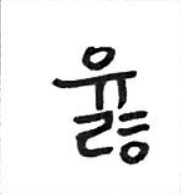

In [26]:
# 이미지를 하나 넣기
import os

image_path = 'D:\yoon_data\korean_consonant_project\Korean_letters\handwritten\syllable_02\\01154647.png'
model_path = "C:\\Users\\jihyu\\OneDrive\\문서\\ds_study\\ResNet_consonants_model.h5"

answers = draw_Hangul_consonants(image_path, model_path)[0]

1/1 [==============================] - 0s 207ms/step
예측 답안: 쎱


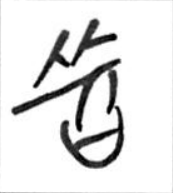

In [27]:
image_path = 'D:\yoon_data\korean_consonant_project\Korean_letters\handwritten\syllable_01\\00085508.png'
answers = draw_Hangul_consonants(image_path, model_path)[0]